In [12]:
%pip install imblearn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# Install first
# pip install sdv pandas scikit-learn seaborn xgboost imblearn
import numpy as np
import pandas as pd
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer

#  Pima India Diabetes dataset
data = pd.read_csv('diabetes.csv')
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[cols_with_zero] = data[cols_with_zero].replace(0, np.nan)

# fill NaN with column mean
data.fillna(data.mean(), inplace=True)  

print(data.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.435949      12.096346       8.790942   85.021108   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.202592      29.153420  155.548223   
75%       6.000000  140.250000      80.000000      32.000000  155.548223   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.457464                  0.471876   33.240885    0.348958  
std      6.875151                  0.331329   11.760232    0.476951  
min     18.200000                  

Plotting Distributions

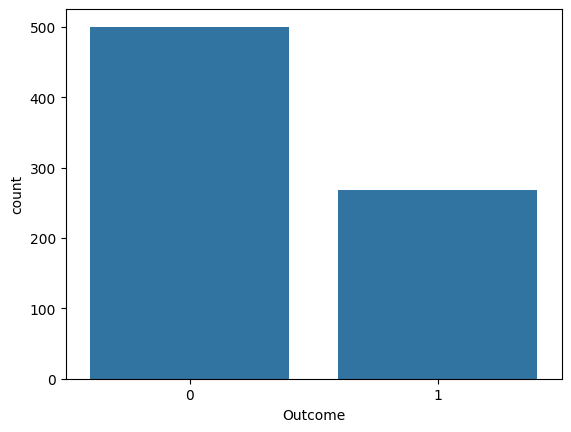

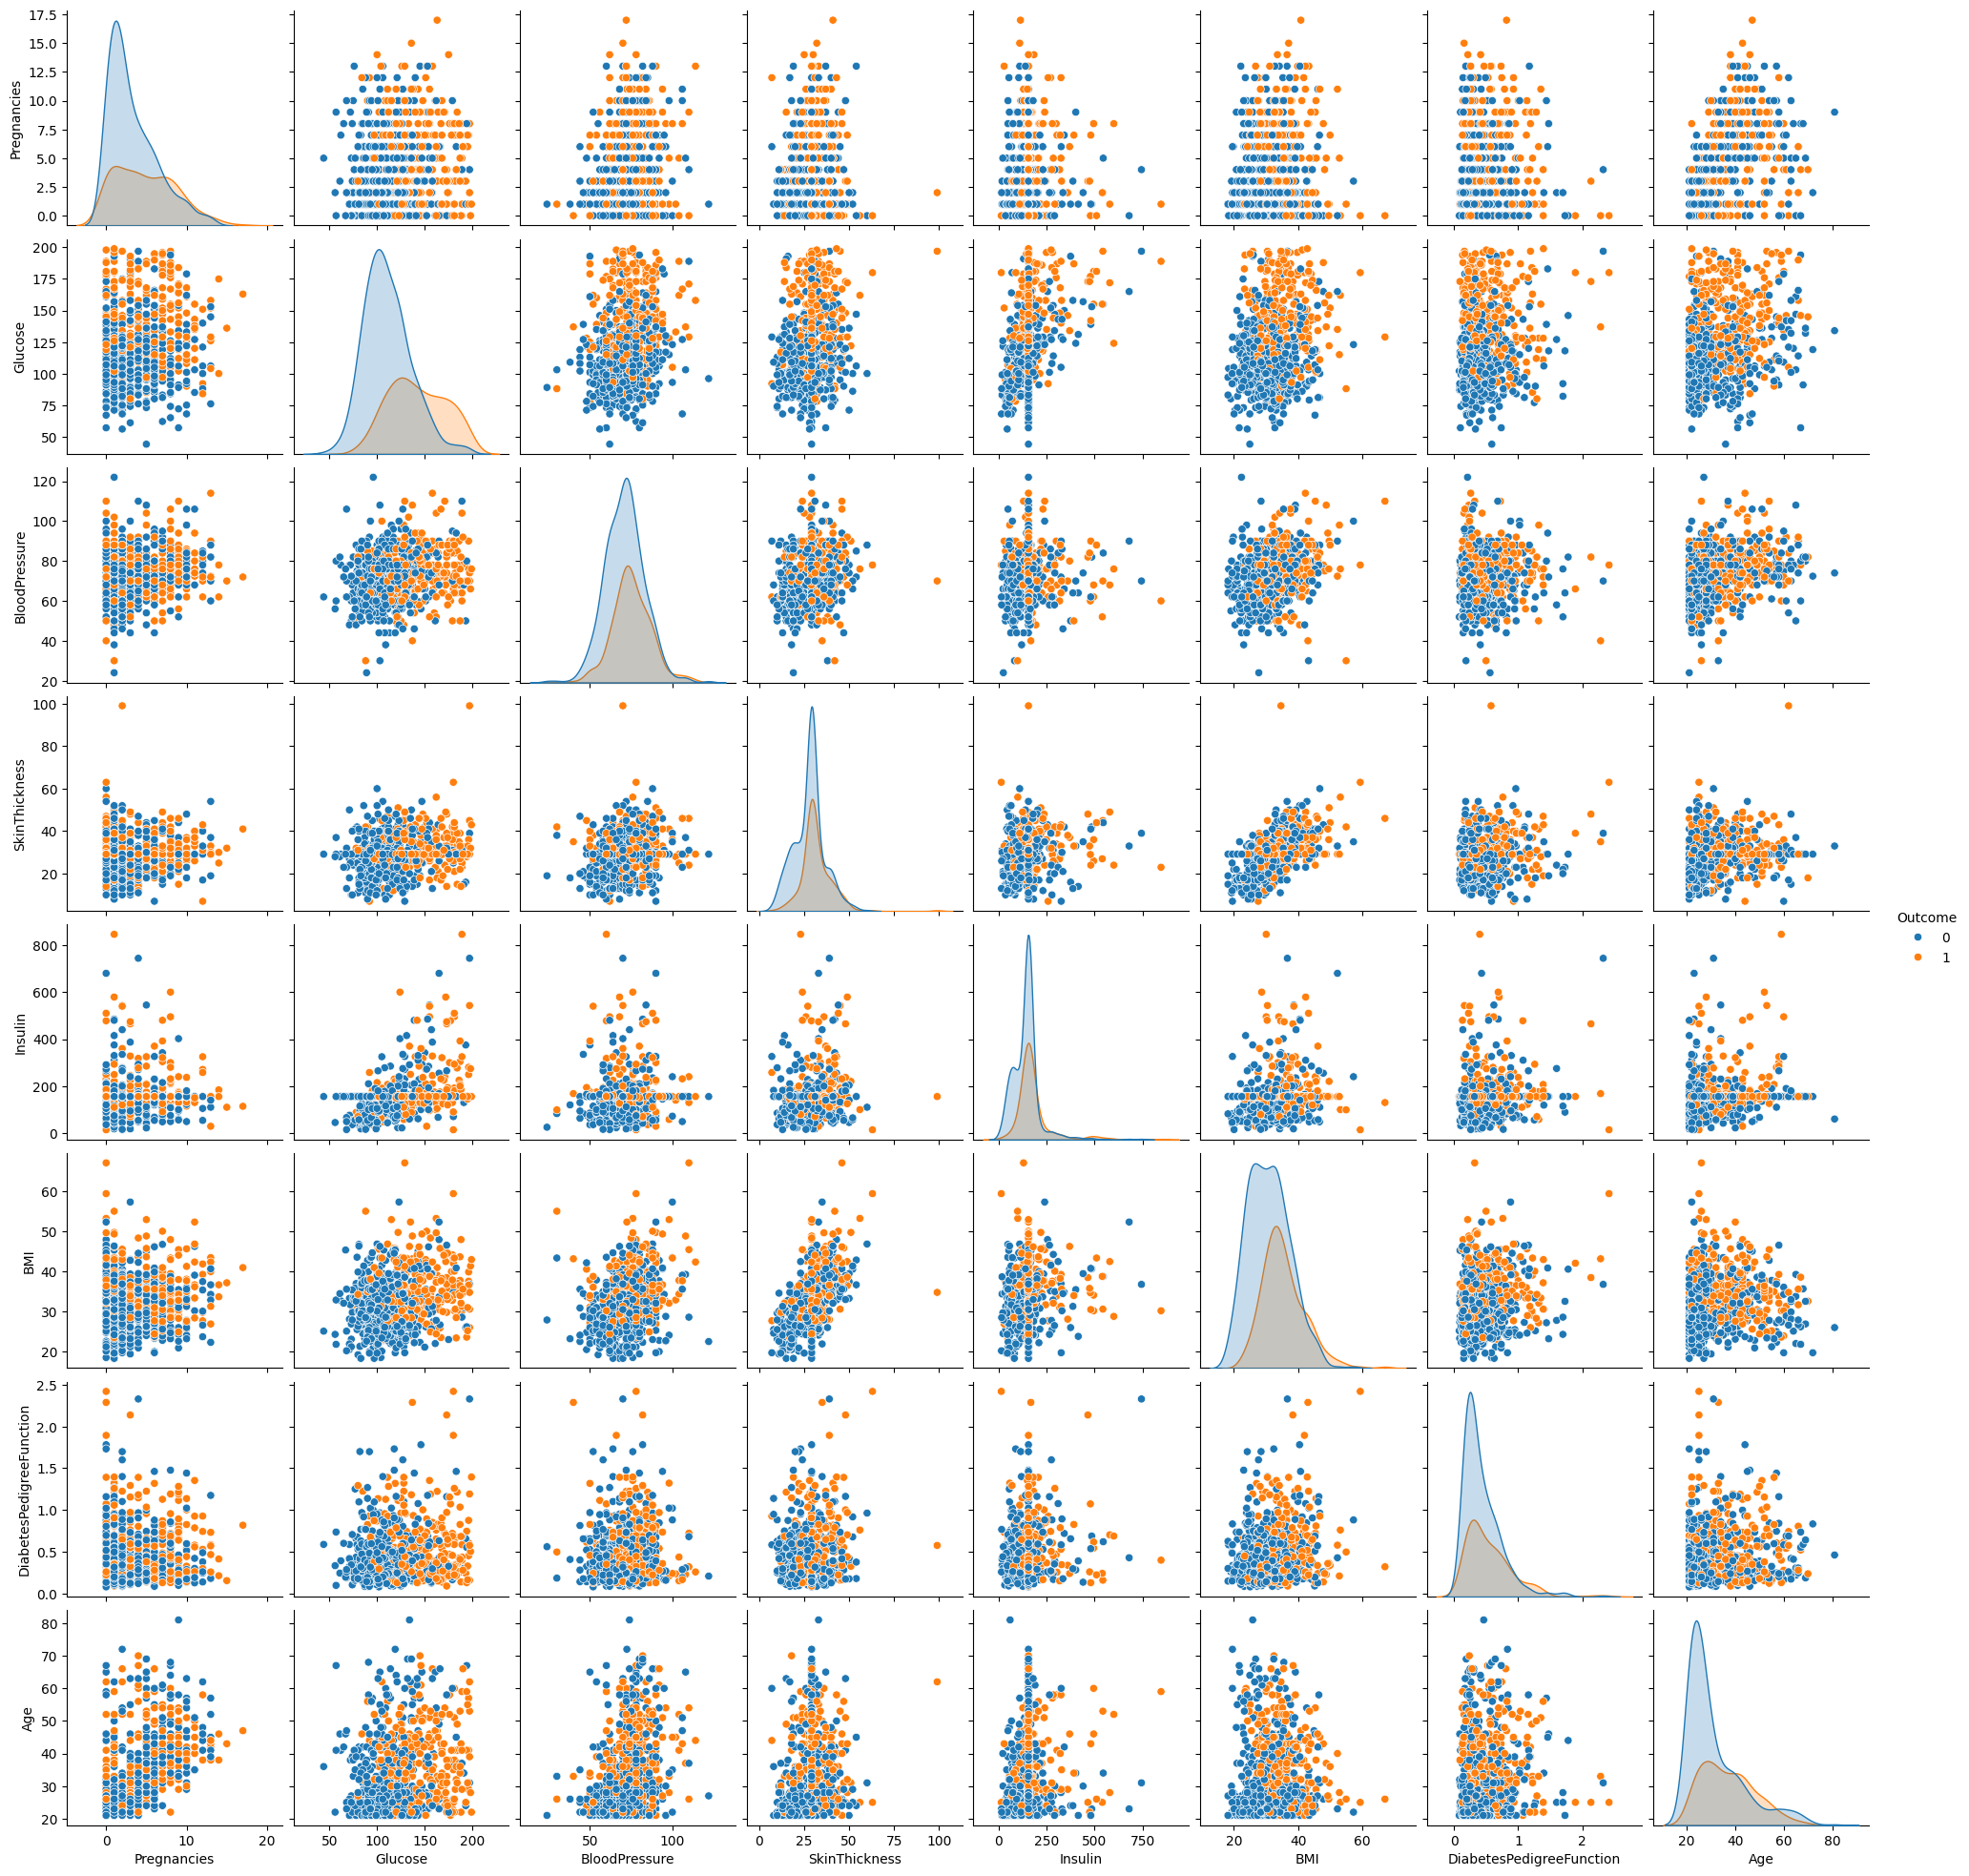

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Outcome', data=data)
plt.show()

sns.pairplot(data, hue='Outcome')
plt.show()


HEATMAP CORELATION

<Axes: >

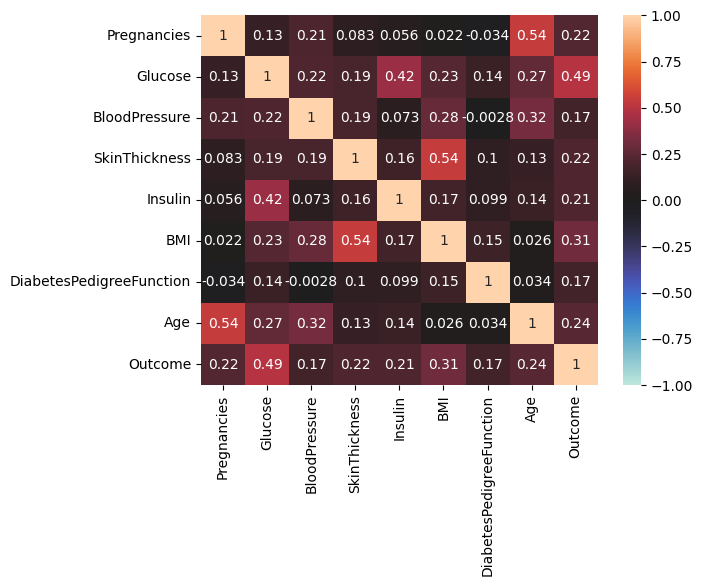

In [15]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True, vmin=-1.0, vmax=1.0, center=0)

**CTGAN Model**

CTGAN stands for Conditional Tabular Generative Adversarial Network. It’s a specialized type of GAN (Generative Adversarial Network) designed to generate synthetic tabular data, especially when the dataset contains a mix of continuous and categorical variables — which is common in real-world structured datasets (e.g., finance, healthcare, marketing).
Like a standard GAN, CTGAN has: Generator( Creates synthetic tabular data ), Discriminator( Tries to distinguish between real and synthetic data), Conditional Vector ( A key addition. Helps CTGAN generate realistic categorical values by conditioning the generator on one-hot encoded representations ).

In [16]:
metadata = Metadata.detect_from_dataframe(
    data=data,
    table_name='diabetes')
# Step 2: Train model
ctgan_model = CTGANSynthesizer( metadata, # required
    enforce_rounding=False,
    epochs=350,
    verbose=True)
ctgan_model.fit(data)

c:\Users\lenovo\Desktop\minor-project\streamlit-venv\Lib\site-packages\sdv\single_table\base.py:105: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (-1.84) | Discrim. (0.08): 100%|██████████| 350/350 [00:13<00:00, 25.14it/s] 


Loss Function

A loss function is a mathematical function used in machine learning and deep learning to measure how far off a model's predictions are from the actual (true) values.
During training the model makes a prediction, Loss function compares it to the ground truth, Loss is minimized using backpropagation and an optimizer like Adam or SGD.

In [17]:
ctgan_model.get_loss_values_plot()

Generate Synthetic Data

In [18]:
# Generate synthetic data
synthetic_data = ctgan_model.sample(1000)

print(synthetic_data.head())

   Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
0            3  146.961114      69.984647      14.427478  255.026588   
1            6   77.307650      96.137441      28.402461  162.144588   
2           10  199.000000      79.276013      16.910650  376.461019   
3           13   82.339612      78.618650      23.719126  145.895809   
4            9  102.019459      61.514863      29.649683   14.000000   

         BMI  DiabetesPedigreeFunction  Age  Outcome  
0  67.100000                  0.210390   30        0  
1  28.360830                  0.268191   51        1  
2  55.487545                  0.316302   30        0  
3  32.298568                  0.599649   21        1  
4  42.948195                  0.341648   75        0  


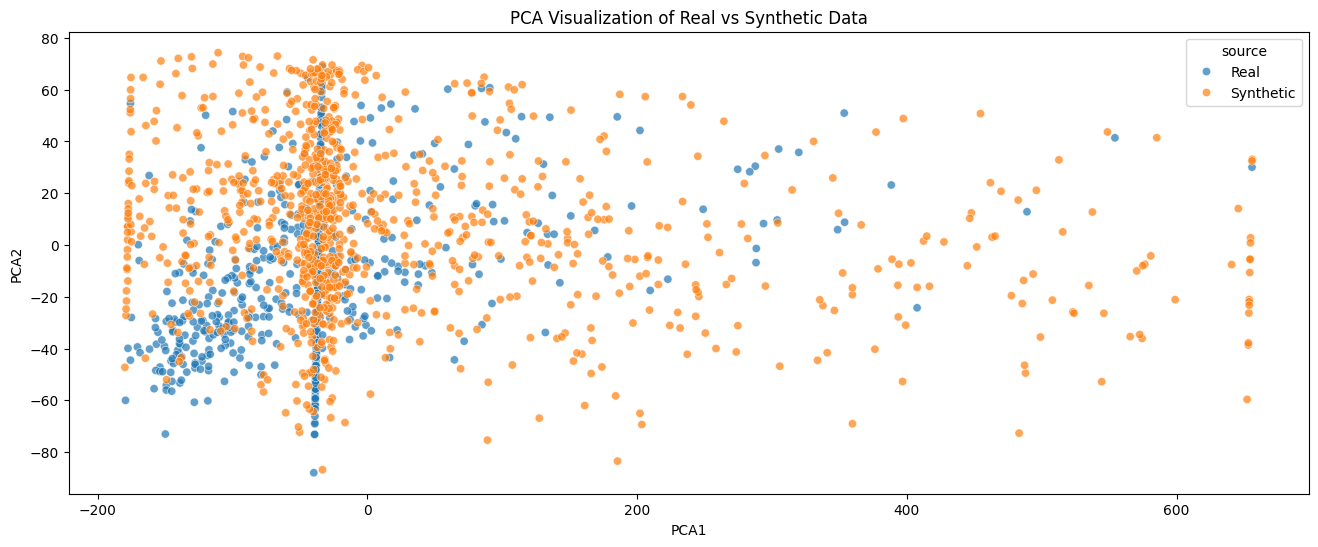

In [19]:
from sklearn.decomposition import PCA

# Combine data
data['source'] = 'Real'
synthetic_data['source'] = 'Synthetic'

combined = pd.concat([data, synthetic_data])

# Drop 'Outcome' if needed
features = combined.drop(['source'], axis=1)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

combined['PCA1'] = pca_result[:,0]
combined['PCA2'] = pca_result[:,1]

# Plot
plt.figure(figsize=(16,6))
sns.scatterplot(data=combined, x='PCA1', y='PCA2', hue='source', alpha=0.7)
plt.title('PCA Visualization of Real vs Synthetic Data')
plt.show()


**Tests**


In [23]:
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.reports.single_table import DiagnosticReport
metadata_dict = metadata.to_dict()
metadata_dict = metadata_dict['tables']['diabetes']
print(metadata_dict)
print(data)
print(synthetic_data)
report = QualityReport()
# Drop 'source' column from synthetic_data if it exists
if 'source' in synthetic_data.columns:
    synthetic_data = synthetic_data.drop(columns='source')
if 'source' in data.columns:
    data = data.drop(columns='source')
report.generate(data,synthetic_data,metadata_dict)

# View overall score
report.get_score()

# Detailed breakdown
# report.get_details('Column Shapes')
# report.get_details('Column Pair Trends')

diagnostic = DiagnosticReport()
diagnostic.generate(data, synthetic_data, metadata_dict)

# Summary
diagnostic.get_score()

# Details
# diagnostic.get_details('Data Validity')
# diagnostic.get_details('Data Structure')


{'columns': {'Pregnancies': {'sdtype': 'numerical'}, 'Glucose': {'sdtype': 'numerical'}, 'BloodPressure': {'sdtype': 'numerical'}, 'SkinThickness': {'sdtype': 'numerical'}, 'Insulin': {'sdtype': 'numerical'}, 'BMI': {'sdtype': 'numerical'}, 'DiabetesPedigreeFunction': {'sdtype': 'numerical'}, 'Age': {'sdtype': 'numerical'}, 'Outcome': {'sdtype': 'categorical'}}}
     Pregnancies  Glucose  BloodPressure  SkinThickness     Insulin   BMI  \
0              6    148.0           72.0       35.00000  155.548223  33.6   
1              1     85.0           66.0       29.00000  155.548223  26.6   
2              8    183.0           64.0       29.15342  155.548223  23.3   
3              1     89.0           66.0       23.00000   94.000000  28.1   
4              0    137.0           40.0       35.00000  168.000000  43.1   
..           ...      ...            ...            ...         ...   ...   
763           10    101.0           76.0       48.00000  180.000000  32.9   
764            2   

np.float64(1.0)

KDE Plot

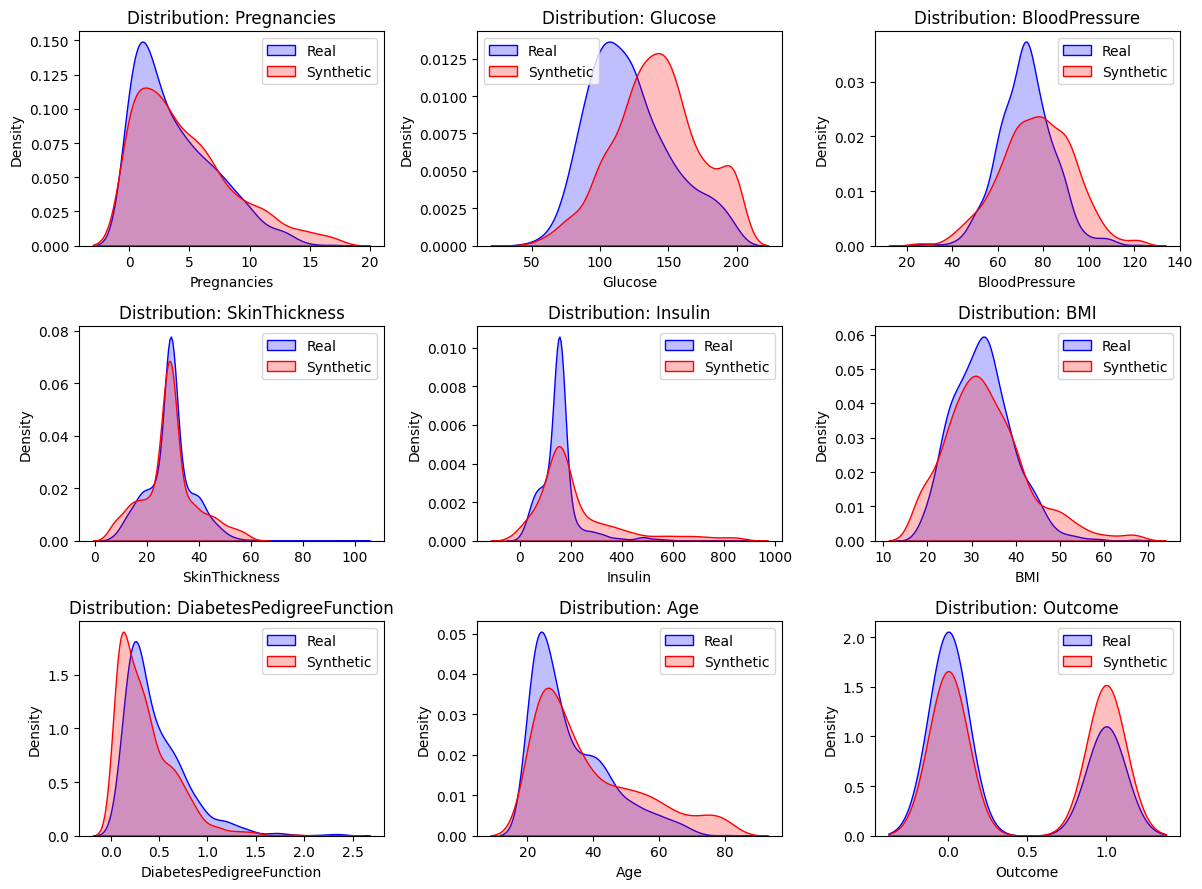

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Filter numeric columns
numeric_columns = data.select_dtypes(include=['number']).columns

# Drop 'source' column from synthetic_data if it exists
if 'source' in synthetic_data.columns:
    synthetic_data = synthetic_data.drop(columns='source')

# Layout: 3 plots per row (adjust as needed)
cols_per_row = 3
total_plots = len(numeric_columns)
rows = math.ceil(total_plots / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, col in enumerate(numeric_columns):
    ax = axes[i]
    sns.kdeplot(data[col], label='Real', fill=True, color='blue', ax=ax)
    sns.kdeplot(synthetic_data[col], label='Synthetic', fill=True, color='red', ax=ax)
    ax.set_title(f'Distribution: {col}')
    ax.legend()

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


HeatMap Corealation Comparision

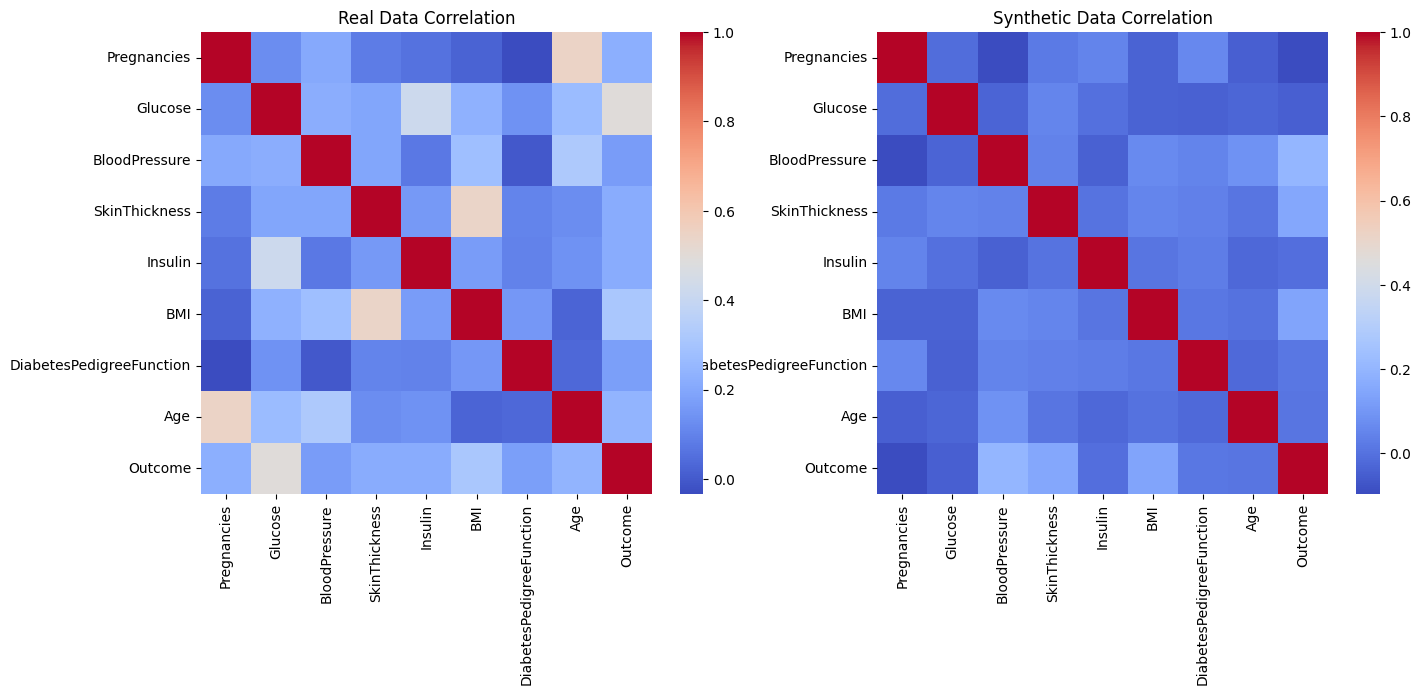

Mean Absolute Correlation Difference: 0.1885


In [25]:
# Correlation matrices
if 'source' in data.columns:
    data = data.drop(columns='source')

real_corr = data.corr()
synthetic_corr = synthetic_data.corr()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(real_corr, ax=axes[0], cmap="coolwarm", annot=False)
axes[0].set_title('Real Data Correlation')

sns.heatmap(synthetic_corr, ax=axes[1], cmap="coolwarm", annot=False)
axes[1].set_title('Synthetic Data Correlation')

plt.show()
# Mean Absolute Error between correlation matrices
correlation_diff = np.abs(real_corr - synthetic_corr)
mean_diff = correlation_diff.values[np.triu_indices_from(correlation_diff, k=1)].mean()

print(f"Mean Absolute Correlation Difference: {mean_diff:.4f}")


Random Forest XGboost LogisticRegression


📊 Model: Random Forest
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       500
           1       0.44      0.49      0.47       268

    accuracy                           0.61       768
   macro avg       0.58      0.58      0.58       768
weighted avg       0.62      0.61      0.61       768


📊 Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       500
           1       0.42      0.46      0.44       268

    accuracy                           0.59       768
   macro avg       0.56      0.56      0.56       768
weighted avg       0.60      0.59      0.59       768



c:\Users\lenovo\Desktop\minor-project\streamlit-venv\Lib\site-packages\xgboost\training.py:183: UserWarning:

[00:30:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.





📊 Model: XGBoost
              precision    recall  f1-score   support

           0       0.71      0.56      0.62       500
           1       0.41      0.58      0.48       268

    accuracy                           0.56       768
   macro avg       0.56      0.57      0.55       768
weighted avg       0.61      0.56      0.57       768



C:\Users\lenovo\AppData\Local\Temp\ipykernel_5824\268656141.py:74: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

c:\Users\lenovo\Desktop\minor-project\streamlit-venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



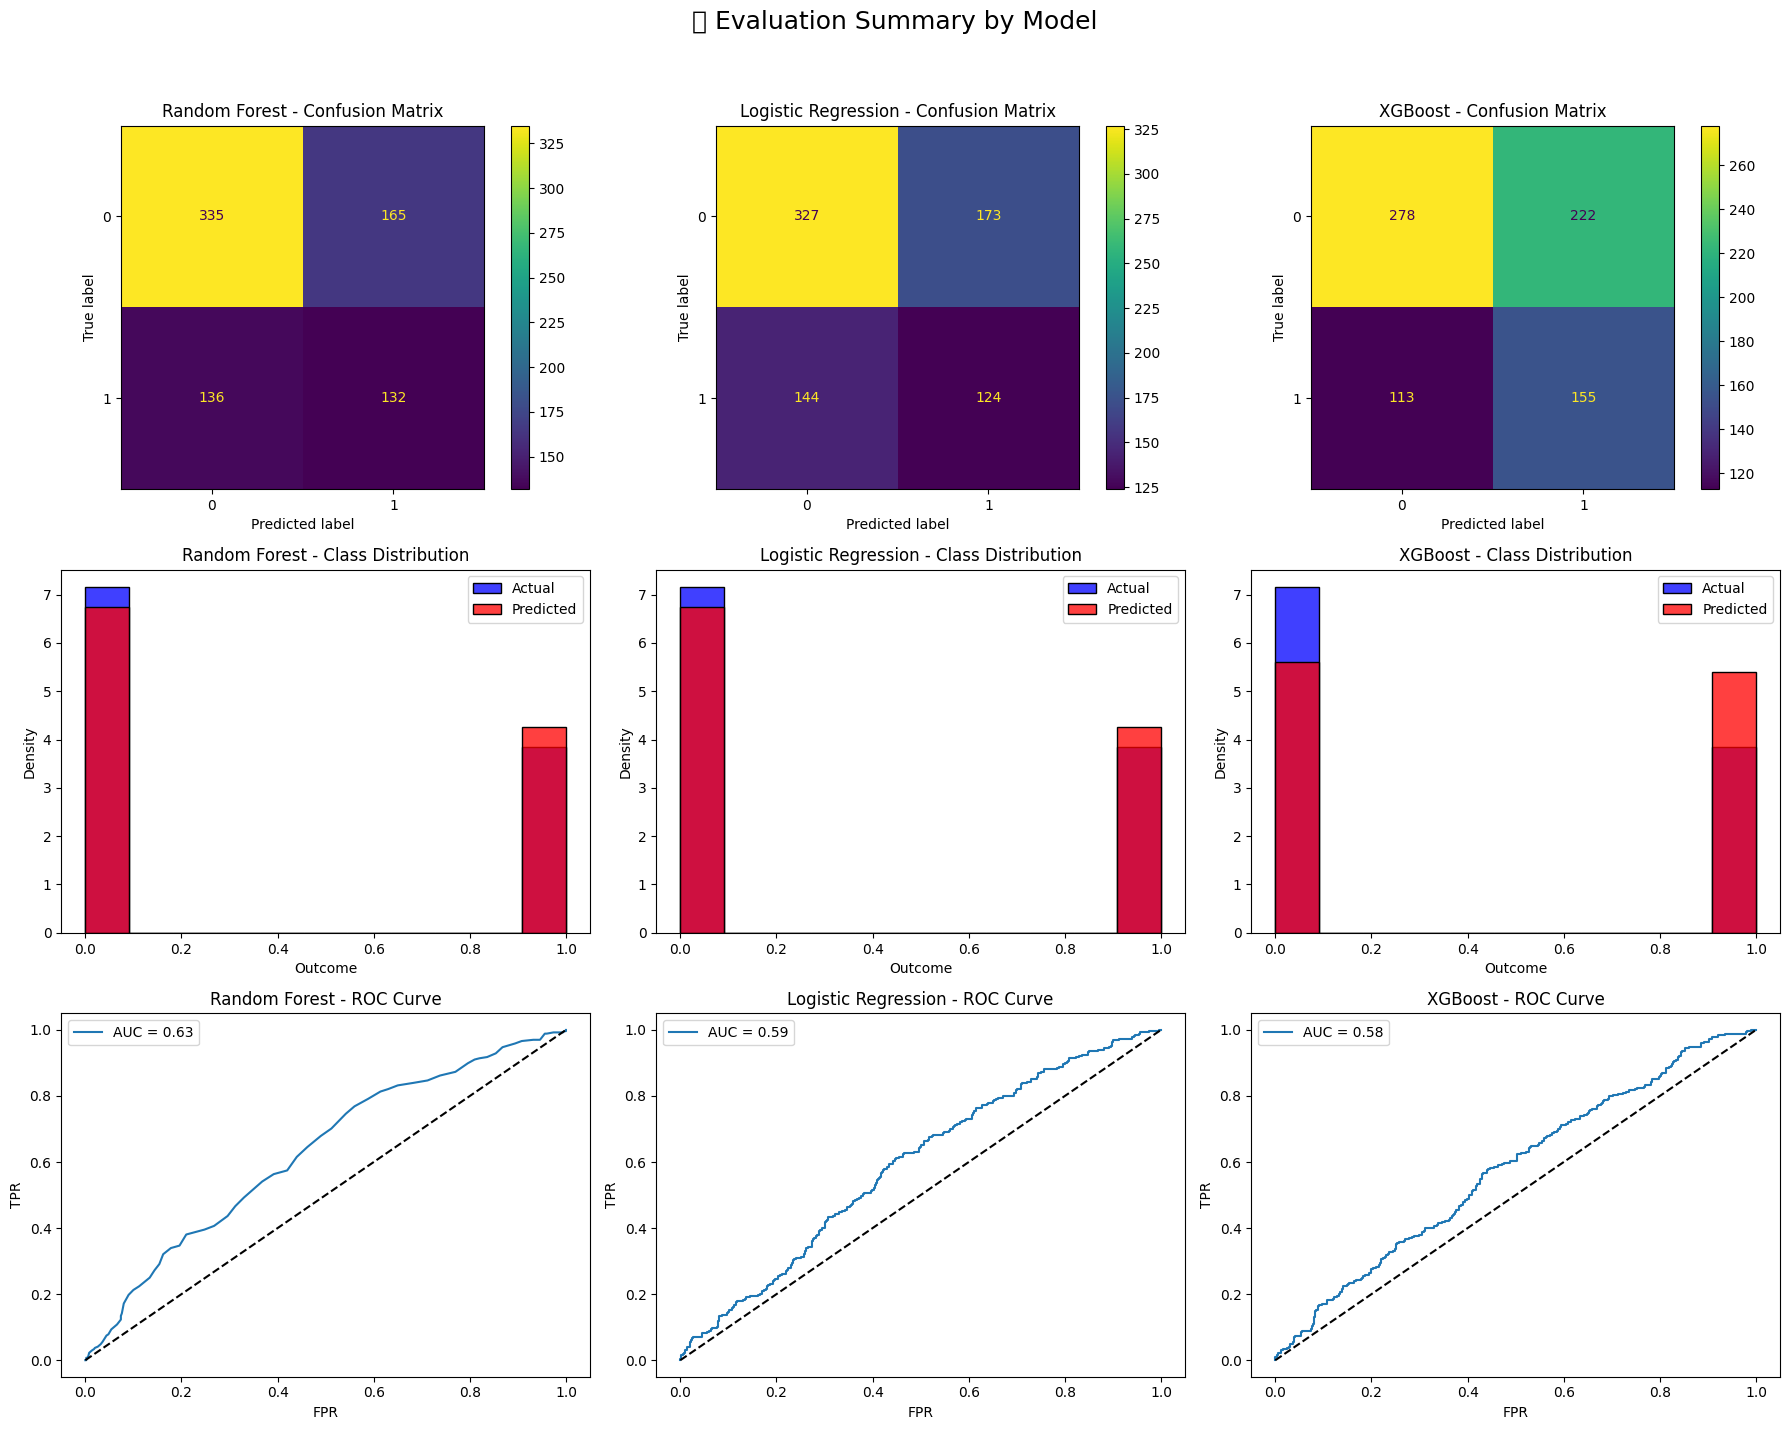

In [27]:

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
from sklearn.model_selection import train_test_split



# 🎯 Define target column
target_col = 'Outcome'  # Change this to your actual target column name

# 🧪 Split features and labels
X_synth = synthetic_data.drop(columns=[target_col])
y_synth = synthetic_data[target_col]

X_real = data.drop(columns=[target_col])
y_real = data[target_col]

# 🔁 Train/Test Models
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

# Prepare 3 rows: Confusion Matrix, Class Dist, ROC Curve
fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(6 * len(models), 15))
fig.suptitle('📊 Evaluation Summary by Model', fontsize=18)

for col_idx, (name, model) in enumerate(models.items()):
    # Train
    model.fit(X_synth, y_synth)
    y_pred = model.predict(X_real)
    y_prob = model.predict_proba(X_real)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f"\n📊 Model: {name}")
    print(classification_report(y_real, y_pred))

    # Row 0: Confusion Matrix
    cm = confusion_matrix(y_real, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=axes[0, col_idx])
    axes[0, col_idx].set_title(f'{name} - Confusion Matrix')

    # Row 1: Class Distribution
    sns.histplot(y_real, label='Actual', kde=False, color='blue', stat='density', ax=axes[1, col_idx])
    sns.histplot(y_pred, label='Predicted', kde=False, color='red', stat='density', ax=axes[1, col_idx])
    axes[1, col_idx].set_title(f'{name} - Class Distribution')
    axes[1, col_idx].legend()

    # Row 2: ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_real, y_prob)
        roc_auc = auc(fpr, tpr)
        axes[2, col_idx].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        axes[2, col_idx].plot([0, 1], [0, 1], 'k--')
        axes[2, col_idx].set_xlabel("FPR")
        axes[2, col_idx].set_ylabel("TPR")
        axes[2, col_idx].set_title(f'{name} - ROC Curve')
        axes[2, col_idx].legend()

    results[name] = {
        'y_pred': y_pred,
        'y_prob': y_prob
    }

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [28]:
# Assuming your trained model is called 'ctgan'
ctgan_model.save('ctgan_model_final.pkl')